# Temperature OEPS expanded for the double-well model
how will it be compared to REX?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.display import clear_output
from tqdm.auto import trange, tqdm

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
import torch

import bgflow as bg
from bgflow.utils.types import assert_numpy

In [5]:
dtype = torch.float32
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu') # force cpu. about same speed for alanine

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = {"device": device, "dtype": dtype}
ctx

{'device': device(type='cpu'), 'dtype': torch.float32}

In [6]:
#define the openmm system
class WolfeQuappOpenMM():
    def __init__(self, model=bg.ModifiedWolfeQuapp(2)):
        Mueller_potential = openmm.CustomExternalForce(model.potential_str)
        Mueller_potential.addParticle(0)
        # print(Mueller_potential.getEnergyFunction())

        system = openmm.System()
        system.addParticle(1.0)
        system.addForce(Mueller_potential)
        if dim > 3:
            normal_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*(x^2+y^2+z^2)')
            # print(normal_potential.getEnergyFunction())
            for i in range((dim-1)//3):
                normal_potential.addParticle(i+1)
                system.addParticle(1.0)
            system.addForce(normal_potential)

        topology = openmm.app.topology.Topology()
        init_posA = np.array([[-1.5, 0.7, 0]]) #basin A
        init_posB = np.array([[2, -1.0, 0]]) #basin B
        if dim > 3:
            init_posA = np.append(init_posA, [0.0]*((dim-1)//3)*3).reshape(-1, 3)
            init_posB = np.append(init_posB, [0.0]*((dim-1)//3)*3).reshape(-1, 3)
            
        self.system = system
        self.topology = topology
        self.positions = init_posA
        self.pos_basinA = init_posA
        self.pos_basinB = init_posB
        self.base_dim = 3 * len(init_posA)
        self.dim = dim

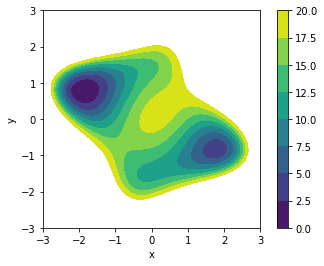

In [7]:
#some plotting functions
#this should be compatible with the default ModifiedWolfeQuapp
def WolfeQuapp2D(x, y, theta=-0.3*np.pi/2, scale=2):
    if theta == 0:
        ene = x**4 + y**4 - 2 * x**2 - 4 * y**2 + 2 * x * y + 0.8 * x + 0.1 * y
        shift = 9.28
        return scale * (ene + shift)
    else:
        c=np.cos(theta)
        s=np.sin(theta) 
        return WolfeQuapp2D(c*x-s*y, s*x+c*y, theta=0, scale=scale)

nbins = 101
x_bins = np.linspace(-3, 3, nbins)
y_bins = np.linspace(-3, 3, nbins)
X, Y = np.meshgrid(x_bins,y_bins)
MuellerXY = WolfeQuapp2D(X,Y)

FES = np.zeros(len(x_bins))
for i,x in enumerate(x_bins):
    FES[i] = -np.logaddexp.reduce(-np.array([WolfeQuapp2D(x,y) for y in y_bins]))
FES -= min(FES)

def plot_mueller(traj=None, traj2=None, grid=False):
    levels = np.linspace(0,20,9)
    
    plt.contourf(X, Y, MuellerXY, levels)
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.yticks(np.arange(0,2.1,.5))
    if grid:
        plt.grid(linestyle='dashed')
    if traj is not None:
        xy_samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '.r')
        # plt.contour(X, Y, MuellerXY, levels[::2])
    if traj2 is not None:
        xy_samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '+m')
        # plt.plot(xy_samples[:,0], xy_samples[:,1], ',r')
    plt.show()
    
def plot_fes(data, temp=1/kB, bins='auto', w=None, show=True):
    x_samples = assert_numpy(data)
    beta = 1/(temp*kB)
    FES_t = [-np.logaddexp.reduce(-np.array([beta*WolfeQuapp2D(x,y) for y in y_bins])) for x in x_bins]
    FES_t -= min(FES_t)
    plt.plot(x_bins, FES_t, '--', label='reference')
    # fes_estimate = -gaussian_kde(x_samples, weights=w).logpdf(x_bins)
    # fes_estimate -= min(fes_estimate)
    # plt.plot(x_bins, fes_estimate, label='estimate')
    if w is not None and bins == 'auto':
        bins = 50
    hist, edges = np.histogram(x_samples, bins=bins, weights=w)
    fes_estimate = -np.log(np.where(hist!=0, hist/hist.max(), np.nan))
    xrange = edges[:-1]+(edges[1]-edges[0])/2
    plt.plot(xrange, fes_estimate, label='estimate')
    plt.xlabel('x')
    plt.ylabel('FES')
    plt.ylim(0, FES_t[-1])
    plt.xlim(x_bins[0], x_bins[-1])
    plt.legend()
    if show:
        plt.show()
    fes_estimate[np.isnan(fes_estimate)] = 1000
    
    print(f'ref DeltaF: {np.logaddexp.reduce(-FES_t[x_bins<0])-np.logaddexp.reduce(-FES_t[x_bins>0]):g} [kBT]')
    # print(f'    DeltaF: {np.logaddexp.reduce(-fes_estimate[x_bins<0])-np.logaddexp.reduce(-fes_estimate[x_bins>0]):g} [kBT]')
    print(f'    DeltaF: {np.logaddexp.reduce(-fes_estimate[xrange<0])-np.logaddexp.reduce(-fes_estimate[xrange>0]):g} [kBT]')

plot_mueller()

## run MD

In [116]:
#setup the system
dim = 2**12
n_temps = 40
lowT = 1 / kB
highT = 5 / kB

model = bg.ModifiedWolfeQuapp(dim)
modelMD = WolfeQuappOpenMM(model)

#cheap consistency check with plotting setup
point = 2*(np.random.sample(2)-1)
assert np.isclose(WolfeQuapp2D(*point), bg.ModifiedWolfeQuapp(2).energy(torch.as_tensor(point)).item())

modelMD.dim, modelMD.positions.shape, modelMD.base_dim

(4096, (1366, 3), 4098)

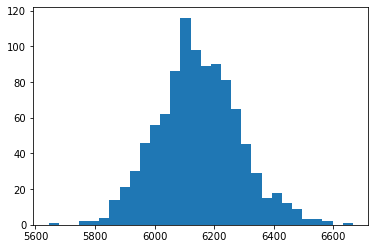

Temperatures: [0.94 0.98 1.02 1.07 1.12 1.16 1.22 1.27 1.32 1.38 1.44 1.51 1.57 1.64
 1.71 1.79 1.87 1.95 2.03 2.12 2.21 2.31 2.41 2.52 2.63 2.74 2.86 2.99
 3.12 3.26 3.4  3.55 3.7  3.87 4.04 4.21 4.4  4.59 4.79 5.  ]
Initial DeltaFs: [13471.41 12648.43 11859.98 11104.6  10380.9   9687.57  9023.32  8386.94
  7777.25  7193.13  6633.52  6097.39  5583.74  5091.64  4620.19  4168.51
  3735.78  3321.2   2924.02  2543.49  2178.93  1829.66  1495.04  1174.46
   867.32   573.07   291.17    21.09  -237.66  -485.56  -723.06  -950.59
 -1168.58 -1377.43 -1577.51 -1769.2  -1952.85 -2128.8  -2297.36 -2458.86]
Mean energy: 6147.147315917969
CPU times: user 2.55 s, sys: 196 ms, total: 2.74 s
Wall time: 2.62 s


In [117]:
%%time
#setup target parameters
temp = (highT+lowT)/2
Tmin = lowT - (highT+lowT)/100
Tmax = highT
temp_steps = n_temps

#initialize useful variables
beta = 1/temp/kB
temperatures = np.geomspace(Tmin, Tmax, temp_steps) 
df_size = temp_steps
running_df = np.zeros(temp_steps)
rct = 0
counter = 1

#setup things for MD run
pace = 100
integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate the system and intialize the DeltaFs
n_equil = 1000
simulation.step(pace*n_equil)
ener = np.zeros(n_equil)
for n in range(n_equil):
    simulation.step(pace)
    ener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    print(f'sampling...  {(n+1)/n_equil:.1%}', end='\r')
mean_ener = np.mean(ener)
for i in range(df_size):
    running_df[i] = (temp/temperatures[i]-1) * mean_ener

equil_pos = simulation.context.getState(getPositions=True).getPositions()

#print some info
plt.hist(ener, bins='auto')
plt.show()
with np.printoptions(precision=2):
    print('Temperatures:', temperatures*kB)
    print('Initial DeltaFs:', running_df)
    print('Mean energy:', mean_ener)

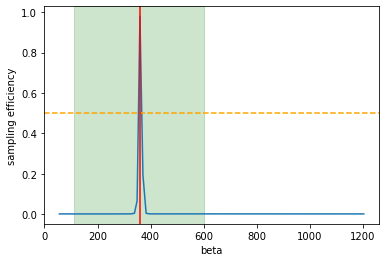

 spacing: 0.01168708326906594
N steps: 73.9132


In [118]:
#visualize Neff
def Neff_b(b):
    return np.exp(2*np.logaddexp.reduce(b*ener)-np.logaddexp.reduce(2*b*ener))/len(ener)-.5

s = 2
b_range = np.linspace(1/(Tmax*s*kB)-beta, 1/(Tmin/s*kB)-beta, 200)
Neffs = np.array([ Neff_b(b)+.5 for b in b_range])
plt.plot(1/(b_range+beta)/kB, Neffs)
plt.axhline(y=.5, c='orange', linestyle='dashed')
plt.axvline(x=temp, c='red')
plt.axvspan(Tmin, Tmax, color='green', alpha=0.2)
plt.xlabel("beta")
plt.ylabel("sampling efficiency")
plt.show()

from scipy.optimize import brentq
right_HWHM = brentq(Neff_b, 0, b_range[-1])
left_HWHM = brentq(Neff_b, 0, b_range[0])
print(' spacing:', right_HWHM - left_HWHM)
print(f'N steps: {(np.abs((1/Tmin-1/Tmax)/kB)/(right_HWHM - left_HWHM)):g}')

In [119]:
# setup biased model using CustomCVForce
import copy

modelOPES = WolfeQuappOpenMM(model)
robust_bias = False #slower, set True only if the bias becomes nan at beginning of simulation
num_forces = modelOPES.system.getNumForces()

# define bias
ene_str = '('+'+'.join([f'u{k}' for k in range(num_forces)])+')'
if not robust_bias:
    bias_str = '-1/beta*log((0'
    for i in range(df_size):
        bias_str += f'+exp(beta*((1-temp/{temperatures[i]})*{ene_str}+df{i}))'
    bias_str += f')/{df_size}); beta={beta}; temp={temp}'
else:
    # use LogSumExp for stability, but much slower
    bias_str = f'-1/beta*(diffMax+log(1/{df_size}*(0' #this is with LogSumExp
    for i in range(df_size):
        bias_str += f'+exp(diff{i}-diffMax)'
    bias_str += f'))); diffMax=max(diff0,diffMax1)'
    for i in range(1, df_size-2):
        bias_str += f'; diffMax{i}=max(diff{i},diffMax{i+1})'
    bias_str += f'; diffMax{df_size-2}=max(diff{df_size-2},diff{df_size-1})'
    for i in range(df_size):
        bias_str += f'; diff{i}=beta*((1-temp/{temperatures[i]})*{ene_str}+df{i})'
    bias_str += f'; beta={beta}; temp={temp}'
print(bias_str)

# add bias to forces
bias_potential = openmm.CustomCVForce(bias_str)
for i in range(df_size):
    bias_potential.addGlobalParameter(f'df{i}', running_df[i])
ener_group = 0
bias_group = 1
for k in range(num_forces):
    modelOPES.system.getForce(k).setForceGroup(ener_group)
    bias_potential.addCollectiveVariable(f'u{k}', copy.deepcopy(modelOPES.system.getForces()[k]))
modelOPES.system.addForce(bias_potential)
modelOPES.system.getForce(modelOPES.system.getNumForces()-1).setForceGroup(bias_group)
modelOPES.system.getForces()

-1/beta*log((0+exp(beta*((1-temp/113.05601374016247)*(u0+u1)+df0))+exp(beta*((1-temp/118.00624895444072)*(u0+u1)+df1))+exp(beta*((1-temp/123.17323361765129)*(u0+u1)+df2))+exp(beta*((1-temp/128.56645825329056)*(u0+u1)+df3))+exp(beta*((1-temp/134.19582893394428)*(u0+u1)+df4))+exp(beta*((1-temp/140.0716854763909)*(u0+u1)+df5))+exp(beta*((1-temp/146.20482043338785)*(u0+u1)+df6))+exp(beta*((1-temp/152.60649891702855)*(u0+u1)+df7))+exp(beta*((1-temp/159.28847929007617)*(u0+u1)+df8))+exp(beta*((1-temp/166.26303476328448)*(u0+u1)+df9))+exp(beta*((1-temp/173.54297593836924)*(u0+u1)+df10))+exp(beta*((1-temp/181.141674338042)*(u0+u1)+df11))+exp(beta*((1-temp/189.0730869663198)*(u0+u1)+df12))+exp(beta*((1-temp/197.35178194422767)*(u0+u1)+df13))+exp(beta*((1-temp/205.9929652679753)*(u0+u1)+df14))+exp(beta*((1-temp/215.01250873876063)*(u0+u1)+df15))+exp(beta*((1-temp/224.4269791154993)*(u0+u1)+df16))+exp(beta*((1-temp/234.25366854402404)*(u0+u1)+df17))+exp(beta*((1-temp/244.51062631865096)*(u0+u1)+d

[<openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7f6f01218ba0> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7f6e5c2684b0> >,
 <openmm.openmm.CustomCVForce; proxy of <Swig Object of type 'OpenMM::CustomCVForce *' at 0x7f6e5c268420> >]

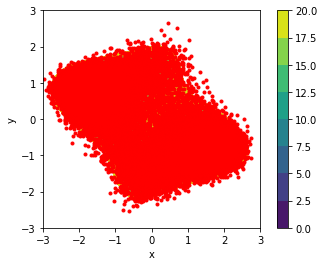

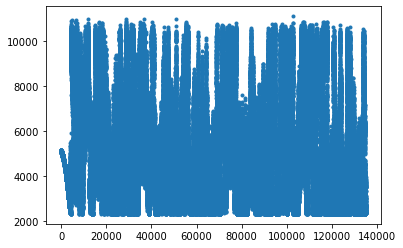

In [ ]:
%%time
# OPES biased MD run

n_iter = 10_000 * min(15, len(temperatures))
integrator = openmm.LangevinIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelOPES.topology, modelOPES.system, integrator)
simulation.context.setPositions(equil_pos)

data = np.full((n_iter, 2), np.nan)
ener = np.full(n_iter, np.nan) # needed for reweighting
bias = np.full(n_iter, np.nan) # needed for reweighting
all_df = np.full((n_iter, len(running_df)), np.nan)
all_rct = np.full(n_iter, np.nan)

for n in range(n_iter):
    simulation.step(pace)
    data[n] = np.array(simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))[0,:2]
    ener[n] = simulation.context.getState(getEnergy=True, groups={ener_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    bias[n] = simulation.context.getState(getEnergy=True, groups={bias_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    ##### update DeltaFs
    increment = 1/beta*np.log1p(np.exp(beta*(bias[n]-rct))/counter)
    for i in range(df_size):
        diff_i = beta*((1-temp/temperatures[i])*ener[n]+bias[n]-rct+running_df[i])
        running_df[i] += increment - 1/beta*np.log1p(np.exp(diff_i)/counter)
        simulation.context.setParameter(f'df{i}', running_df[i])
    counter += 1
    rct += increment + 1/beta*np.log1p(-1/counter)
    ##### 
    all_df[n] = running_df
    all_rct[n] = rct
    # print info
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_mueller(data[:n+1])
        plt.plot(ener, '.')
        plt.show()
    print(f'sampling...  {n/n_iter:.2%}, beta*df[0] = {beta*running_df[0]:g}, beta*df[-1] = {beta*running_df[-1]:g}', end='\r')
#     print(f'sampling...  {n/n_iter:.1%}  bias={bias[n]}',end='\r')[0,:2]

## check results

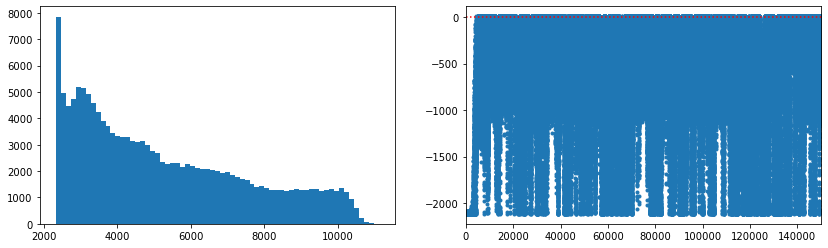

FES at T=3.0


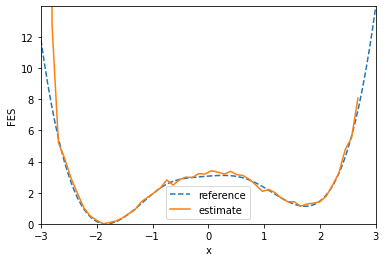

ref DeltaF: 0.968272 [kBT]
    DeltaF: 0.957923 [kBT]


In [126]:
# more plotting
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(ener, bins='auto')

plt.subplot(1,2,2)
plt.plot(bias, '.')
plt.axhline(0, c='r', ls=':')
plt.xlim(0, len(bias))
plt.show()

print(f'FES at T={temp*kB}')
plot_fes(data[:,0], w=np.exp(bias/(temp*kB)), temp=temp)

In [130]:
if df_size<10:
    plt.plot(all_rct, label='rct')
    for i in range(df_size):
        plt.plot(all_df[:,i], label=f'df{i}')
    plt.legend()
    plt.show()

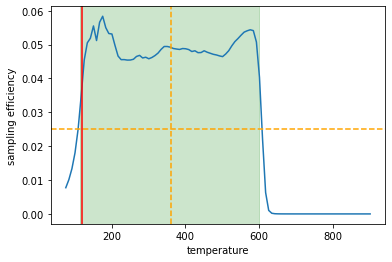

     REX Sampling efficiency: 0.025
Sampling efficiency at T=1.0: 0.0390613
 Effective sample size T=1.0: 1953.07


/tmp/ipykernel_428311/2527301945.py:57: RuntimeWarning: invalid value encountered in true_divide
  fes_estimate = -np.log(np.where(hist!=0, hist/hist.max(), np.nan))


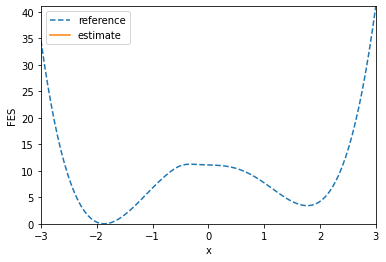

ref DeltaF: 3.31506 [kBT]
    DeltaF: 0 [kBT]


In [138]:
transient = 100_000
myT = 1/kB
myx = data[transient:,0]
mybias = bias[transient:]
myener = ener[transient:]

def sampling_efficiency(logw):
    return np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))/len(logw)

temp_range = np.linspace(Tmin/1.5, Tmax*1.5, 100)
SEs = np.array([ sampling_efficiency(beta*((1-temp/t)*myener+mybias)) for t in temp_range])
plt.plot(temp_range, SEs)
plt.axhline(1/len(temperatures), ls='--', c='orange')
plt.axvspan(Tmin, Tmax, color='green', alpha=0.2)
plt.axvline(x=temp, ls='--', c='orange')
plt.axvline(x=myT, c='red')
plt.xlabel("temperature")
plt.ylabel("sampling efficiency")
# plt.ylim(0,1)
plt.show()

logw = beta * ((1 - temp / myT) * myener + mybias)
print(f'     REX Sampling efficiency: {1/len(temperatures):g}')
print(f'Sampling efficiency at T={myT*kB}: {sampling_efficiency(logw):g}')
print(f' Effective sample size T={myT*kB}: {sampling_efficiency(logw)*len(logw):g}')

plot_fes(myx, w=np.exp(logw), temp=myT)

In [139]:
with open("OPES-dw.txt", "a") as myfile:
    myfile.write(f'{dim}  {len(temperatures)}  {sampling_efficiency(logw):g}\n')

In [140]:
!cat OPES-dw.txt

#N nrep sampling_efficiency_lowT
2  2  0.600416
4  2  0.569047
16  3  0.4
16  4  0.388
64  6  0.249715
256  10  0.1455
1024  20  0.076111
4096  40  0.030893
4096  40  0.0390613
